# The Battle of the Neighborhoods - Open a Tea Room in Vancouver

### Capstone Project - IBM Data Science Professional Certificate - Coursera
***

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [References](#references)
***

## Introduction: Business Problem <a name="introduction"></a>

Vancouver is a major city in western Canada, located in the region of British Columbia. It is one of the most ethnically and linguistically diverse cities in Canada. Almost half of its residents are not native English speakers and belong to visible minority groups, mostly Asians. With its location on the Pacific Rim and at the western terminus of Canada's transcontinental highway and rail routes, Vancouver is one of the nation's largest industrial centres, and it's scenic location makes it a major tourist destination.

In many asian countries, a teahouse is traditionally a place which offers tea to its customers, alongside small plates of food. People gather at teahouses to chat, socialize and enjoy tea, and young people often meet at teahouses for dates. Tea rooms are also popular in Commonwealth countries, particularly Canada, with its harsh winters when afternoon tea is popular. The menu will generally have pastries, butter tarts or other small desserts. 

All these factors combined make Vancouver a perfect city to open a Tea Room. In this project I will try to find an optimal location for a "Tea Room & Pastries" shop. Specifically, __this report will be targeted to stakeholders interested in opening a Tea Room in Vancouver, Canada__.

I will try to detect locations that are not already crowded with tea rooms and similar venues. I will take into account the city's neighborhood demographic diversity and the proximity to tourist attractions to evaluate each location's potential attractiveness to customers.

I will use my data science skills to find the most promissing neighborhoods based on this criteria. Advantages of each area will be described so that the best possible final location can be chosen by stakeholders.

***

## Data <a name="data"></a>

Based on the definition of the problem, the following factors will guide this analysis:
* The number of existing similar venues in the neighborhood (other tea rooms, breakfast spots, etc.)
* The proximity to tourist attractions.
* Each neighborhoods' demographics and its residential or commercial character.

I will use the [postal codes of British Columbia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V) to find Vancouver's neighborhoods names and postal codes. 

I will use the following resources to extract/generate the required information:
- To get the center coordinates of each postal code I will use __Geopy__.
- The data about venues (name, type and location) for each neighborhood will be obtained using **Foursquare API**.
- To find information about the city and it's demographics, I will use [Vancouver's Wikipedia page](https://en.wikipedia.org/wiki/Vancouver), [the city of Vancouver's website](vancouver.ca) and [Tourism Vancouver's website](www.tourismvancouver.com).
***

## Methodology <a name="methodology"></a>

First, I will collect the required data: postal codes and names of Vancouver's neighborhoods, and their location data. For this I will use __BeautifulSoup__ and __geopy__ libraries.

Second, I will use the __Foursquare API__ to explore the neighborhoods. I will set the limit at 100 venues and the radius at 1000 meters for each postal code from their given latitude and longitude coordinates.

Third, I will create clusters of locations in the city using __scikit-learn K-Means algorithm__ to find the areas where Tea Rooms and similar venues are already located. Once I have found these I will analyse the characteristics of the different city clusters (using information available online) to evaluate which locations could be a good spot to open a new Tea Room in Vancouver.

I will use the __folium__ library to visualize the geospatial data and the __matplotlib__ and __seaborn__ libraries to draw informative graphics to better describe my findings.

    Note: Vancouver has 31 postal codes assigned to different zones of the city. These postal codes describe better the city's areas (from a commercial and/or residential point of view) than the neighborhoods names, which have a more historical origin and are sometimes very small geographically. In my analysis I will use 'Neighborhoods', 'city areas' or 'postal code-defined areas' when referring to the different zones being analysed. When using the neighborhood's traditional names I will explicitly state so.

### 1. Web scraping and procuring geospatial data

Let's start by importing the necessary libraries:

In [1]:
import requests
import os
import pandas as pd
import numpy as np
import json

from bs4 import BeautifulSoup

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's start by searching for the postal codes and the names of Vancouver's neighborhoods. Postal codes beginning with V are located within the Canadian province of British Columbia, where Vancouver is located. So I will start by scraping the list of postal codes of Canada from Wikipedia:

In [2]:
# retrieve the URL and create a BeautifulSoup object
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V'
bc_wiki = requests.get(url)
soup = BeautifulSoup(bc_wiki.content, "lxml")

table = soup.find_all('table')[0]
df = pd.read_html(str(table))
bc_data = pd.DataFrame(df[0])
bc_data.rename(columns={'Postcode': 'PostalCode', 'Borough': 'Borough', 'Neighbourhood': 'Neighborhood'}, inplace=True)
print(bc_data.shape)
bc_data.head()

(20, 9)


0                                 1  \
0     V1AKimberley                      V2APenticton   
1    V1BVernonEast              V2BKamloopsNorthwest   
2     V1CCranbrook  V2CKamloopsCentral and Southeast   
3    V1ESalmon Arm         V2EKamloopsSouth and West   
4  V1GDawson Creek                  V2GWilliams Lake   

                                   2                     3  \
0  V3ALangley Township(Langley City)    V4ASurreySouthwest   
1           V3BPort CoquitlamCentral         V4BWhite Rock   
2             V3CPort CoquitlamSouth     V4CDeltaNortheast   
3                  V3ECoquitlamNorth          V4EDeltaEast   
4                  V3GAbbotsfordEast  V4GDeltaEast Central   

                                                   4  \
0  V5ABurnaby(Government Road / Lake City / SFU /...   
1    V5BBurnaby(Parkcrest-Aubrey / Ardingley-Sprott)   
2  V5CBurnaby(Burnaby Heights / Willingdon Height...   
3  V5EBurnaby(Lakeview-Mayfield / Richmond Park /...   
4         V5GBurnaby(Cascade-Schou / Douglas-Gilpin)   

                                                   5  \
0  V6AVancouver(Strathcona / Chinatown / Downtown...   
1  V6BVancouver(NE Downtown / Gastown / Harbour C...   
2  V6CVancouver(Waterfront / Coal Harbour / Canad...   
3          V6EVancouver(SE West End / Davie Village)   
4           V6GVancouver(NW West End / Stanley Park)   

                                                   6                7  \
0                                   V7ARichmondSouth  V8APowell River   
1                      V7BRichmond(Sea Island / YVR)      V8BSquamish   
2                               V7CRichmondNorthwest       V8CKitimat   
3                               V7ERichmondSouthwest      V8EWhistler   
4  V7GNorth Vancouver (district municipality)Oute...       V8GTerrace   

                                                   8  
0  V9AVictoria(Vic West / Esquimalt)Canadian Forc...  
1  V9BVictoria(West Highlands / North Langford / ...  
2  V9CVictoria(Colwood / South Langford / Metchosin)  
3           V9EVictoria(East Highlands / NW Saanich)  
4                                       V9GLadysmith

In this table, each data cell contains a postal code and the city and neighborhood/s it has been assigned to. I will rearrange this data to create a new dataframe with columns named "PostalCode", "City" and "Neighborhood", keeping only Vancouver's postal codes.

In [3]:
### create one list for each column of bc_data
zero = bc_data[0].tolist()
one = bc_data[1].tolist()
two = bc_data[2].tolist()
three = bc_data[3].tolist()
four = bc_data[4].tolist()
five = bc_data[5].tolist()
six = bc_data[6].tolist()
seven = bc_data[7].tolist()
eight = bc_data[8].tolist()

In [4]:
### concatenate all lists and convert to pd.Series
bc_series = pd.Series([zero, one, two, three, four, five, six, seven, eight])
bc_series = bc_series.sum()
### convert Series to DataFrame
bc_df = pd.DataFrame(bc_series)
bc_df.head()

0
0     V1AKimberley
1    V1BVernonEast
2     V1CCranbrook
3    V1ESalmon Arm
4  V1GDawson Creek

In [5]:
### split data into 2 columns: PostalCode, City-Neighborhood
bc_df['PostalCode'] = bc_df[0].str[:3]
bc_df['City-Neighborhood'] = bc_df[0].str[3:]
bc_df.head(10)

0 PostalCode      City-Neighborhood
0              V1AKimberley        V1A              Kimberley
1             V1BVernonEast        V1B             VernonEast
2              V1CCranbrook        V1C              Cranbrook
3             V1ESalmon Arm        V1E             Salmon Arm
4           V1GDawson Creek        V1G           Dawson Creek
5             V1HVernonWest        V1H             VernonWest
6          V1JFort St. John        V1J          Fort St. John
7                V1KMerritt        V1K                Merritt
8                 V1LNelson        V1L                 Nelson
9  V1MLangley TownshipNorth        V1M  Langley TownshipNorth

In [6]:
### create a subdf with Vancouver's data only
vancouver_df = bc_df[bc_df['City-Neighborhood'].str.startswith('Vancouver')]
print(vancouver_df.shape)
vancouver_df.head()

(31, 3)


0 PostalCode  \
87               V5KVancouver(North Hastings-Sunrise)        V5K   
88             V5LVancouver(North Grandview-Woodland)        V5L   
89  V5MVancouver(South Hastings-Sunrise / North Re...        V5M   
90  V5NVancouver(South Grandview-Woodland / NE Ken...        V5N   
91  V5PVancouver(SE Kensington-Cedar Cottage / Vic...        V5P   

                                    City-Neighborhood  
87                  Vancouver(North Hastings-Sunrise)  
88                Vancouver(North Grandview-Woodland)  
89  Vancouver(South Hastings-Sunrise / North Renfr...  
90  Vancouver(South Grandview-Woodland / NE Kensin...  
91  Vancouver(SE Kensington-Cedar Cottage / Victor...

In [7]:
### split City-Neighborhood into 2 columns, named City and Neighborhood
vancouver_df[['City', 'Neighborhood']] = vancouver_df['City-Neighborhood'].str.split('(', expand=True)
### remove the ending ')' from 'Neighborhood' column
vancouver_df['Neighborhood'] = vancouver_df['Neighborhood'].str[:-1]
### drop columns with repeated data
vancouver_df.drop(columns=[0, 'City-Neighborhood'], inplace=True)
vancouver_df.head()

/home/alina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/alina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/alina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

PostalCode       City                                       Neighborhood
87        V5K  Vancouver                             North Hastings-Sunrise
88        V5L  Vancouver                           North Grandview-Woodland
89        V5M  Vancouver  South Hastings-Sunrise / North Renfrew-Colling...
90        V5N  Vancouver  South Grandview-Woodland / NE Kensington-Cedar...
91        V5P  Vancouver  SE Kensington-Cedar Cottage / Victoria-Fraserview

In [8]:
### to avoid problems with SettingWithCopyWarning, I deep copy the df before reseting the index
vancouver_data = vancouver_df.copy()
vancouver_data.reset_index(drop=True, inplace=True)

In [2]:
# save vancouver_data to .csv
vancouver_data.to_csv('Vancouver_data.csv', index=False)

vancouver_data = pd.read_csv('Vancouver_data.csv')
vancouver_data.head()

PostalCode       City                                       Neighborhood
0        V5K  Vancouver                             North Hastings-Sunrise
1        V5L  Vancouver                           North Grandview-Woodland
2        V5M  Vancouver  South Hastings-Sunrise / North Renfrew-Colling...
3        V5N  Vancouver  South Grandview-Woodland / NE Kensington-Cedar...
4        V5P  Vancouver  SE Kensington-Cedar Cottage / Victoria-Fraserview

Now that I have Vancouver's postal codes, let's find their coordinates with geopy:

In [10]:
from geopy.geocoders import Nominatim # convert an address or postal code into latitude and longitude values

lat = []
long = []

for postal_code in list(vancouver_data['PostalCode']):
    print(postal_code)
    geolocator = Nominatim(user_agent="vancouver_explorer")
    location = geolocator.geocode(postal_code)
    try:
        lat.append(location.latitude)
        long.append(location.longitude)
    except AttributeError: 
        print('---', postal_code)   # this will let me know if there are any coordinates missing
        continue

print("Number of latitude and longitude coordinates found: ", len(lat), '-', len(long), '\n')
print("Latitude coordinates: ", lat, '\n')
print("Longitude coordinates: ", long)

V5K
V5L
V5M
V5N
V5P
V5R
V5S
V5T
--- V5T
V5V
V5W
V5X
V5Y
--- V5Y
V5Z
V6A
V6B
V6C
V6E
V6G
V6H
V6J
V6K
V6L
V6M
V6N
V6P
V6R
V6S
--- V6S
V6T
V6Z
V7X
V7Y
Number of latitude and longitude coordinates found:  28 - 28 

Latitude coordinates:  [49.28171754656246, 49.280200918758624, 49.26007804182507, 49.2646254249102, 49.22275092852469, 49.239822993458404, 49.21604993652559, 49.248424877991, 49.23626244835694, 49.21542495297729, 49.25668694119318, 49.27358514239091, 49.27811172378708, 49.287716588954346, 49.28801282544443, 49.3002702, 49.25680023082197, 49.260907082479285, 49.26895274770836, 49.25123526871763, 49.23445241369216, 49.224594327808234, 49.218349248173894, 49.26911800091252, 49.274648, 49.27844786726529, 49.28600408893013, 49.282806433536955] 

Longitude coordinates:  [-123.0400063294856, -123.06656328873324, -123.0401599764032, -123.06586883849849, -123.06756094152627, -123.04080030032974, -123.04095993051983, -123.09060263719377, -123.09288184184227, -123.09779804646165, -123.1211

For some reason geopy cannot find postal codes V5T, V5Y, V6S, which are assigned to neighborhoods "East Mount Pleasant", "West Mount Pleasant / West Riley Park-Little M..." and "NW Dunbar-Southlands / Chaldecutt / South Univ..." respectively. Since it's only 3 postal codes, I will use Google Maps Search Option to find them:

Google Maps search results:

- V5T: 49.264724, -123.092574
- V5Y: 49.252015, -123.110748
- V6S: 49.251210, -123.225418

I will now insert these values in the 'lat' and 'long' lists, and then create a new dataframe with Vancouver's postal codes coordinates:

In [11]:
# values to insert
postal_codes = list(vancouver_data['PostalCode'])
pc_to_insert = ['V5T', 'V5Y', 'V6S']
lat_to_insert = [49.264724, 49.252015, 49.251210]
long_to_insert = [-123.092574, -123.110748, -123.225418]

print("Number of values in lat and long lists before the insert:", len(lat), '-' ,len(long))

for pc in pc_to_insert:
    index = postal_codes.index(pc)
    lat.insert(index, lat_to_insert[pc_to_insert.index(pc)])
#     print(lat_to_insert[pc_to_insert.index(pc)])
    long.insert(index, long_to_insert[pc_to_insert.index(pc)])
#     print(long_to_insert[pc_to_insert.index(pc)])

print("Number of values in lat and long lists after the insert:", len(lat), '-' ,len(long))

Number of values in lat and long lists before the insert: 28 - 28
Number of values in lat and long lists after the insert: 31 - 31


Good, now I have a complete list of Vancouver's postal codes and their latitude and longitude coordinates. Let's save that data in a .csv file before moving on with the analysis:

In [61]:
df = pd.DataFrame(list(zip(list(vancouver_data['PostalCode']), lat, long)), columns=['PostalCode', 'Latitude', 'Longitude'])
df.to_csv('Vancouver_coordinates.csv', index=False)

And now I can read that data into a dataframe:

In [3]:
# create dataframe with coordinates data for Vancouver's neighborhoods
vancouver_coord = pd.read_csv('Vancouver_coordinates.csv')
vancouver_coord.head()

PostalCode   Latitude   Longitude
0        V5K  49.283277 -123.043293
1        V5L  49.279853 -123.068277
2        V5M  49.265358 -123.049119
3        V5N  49.259254 -123.072063
4        V5P  49.230668 -123.071843

OK, so now I have all the postal codes, neighborhood names and their coordinates! Let's merge all that into a single dataframe named 'neighborhoods':

In [4]:
# merge dataframes
neighborhoods = vancouver_data.merge(vancouver_coord, how='inner', on='PostalCode')
neighborhoods.head()

PostalCode       City                                       Neighborhood  \
0        V5K  Vancouver                             North Hastings-Sunrise   
1        V5L  Vancouver                           North Grandview-Woodland   
2        V5M  Vancouver  South Hastings-Sunrise / North Renfrew-Colling...   
3        V5N  Vancouver  South Grandview-Woodland / NE Kensington-Cedar...   
4        V5P  Vancouver  SE Kensington-Cedar Cottage / Victoria-Fraserview   

    Latitude   Longitude  
0  49.283277 -123.043293  
1  49.279853 -123.068277  
2  49.265358 -123.049119  
3  49.259254 -123.072063  
4  49.230668 -123.071843

In [5]:
print('The dataframe has {} postal codes.'.format(len(neighborhoods['Neighborhood'].unique())))

The dataframe has 31 postal codes.


Let's see what this data looks like in a map:

In [5]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Vancouver, BC, Canada'
geolocator = Nominatim(user_agent="vancouver_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the city of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the city of Vancouver are 49.2608724, -123.1139529.


In [7]:
# create map of Vancouver using latitude and longitude values
map_vancouver = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], 
                                  neighborhoods['Longitude'],
                                  neighborhoods['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)

map_vancouver

##### Map 1. Vancouver's neighborhoods (as defined by their assigned postal codes).

# The map might not be visible on Github. Check out the README for the map.

### 2. Explore Vancouver's Neighborhoods

Now that I have the required geospatial data, let's use the Foursquare API to get info on venues for each neighborhood.

I am particularly interested in venues related to the "Tea & Pastries" categories to use that data to create the clusters, but I will request information on all categories to use it later on the analysis of each of the city's clusters.

In [15]:
# Define Foursquare Credentials and Version
CLIENT_ID = '@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@' # your Foursquare ID
CLIENT_SECRET = '@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    """ names, latitudes, longitudes are columns from a dataframe. """
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
# Run the above function on each neighborhood and create a new dataframe called vancouver_venues.
vancouver_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                            latitudes=neighborhoods['Latitude'],
                            longitudes=neighborhoods['Longitude'])

North Hastings-Sunrise
North Grandview-Woodland
South Hastings-Sunrise / North Renfrew-Collingwood
South Grandview-Woodland / NE Kensington-Cedar Cottage
SE Kensington-Cedar Cottage / Victoria-Fraserview
South Renfrew-Collingwood
Killarney
East Mount Pleasant
West Kensington-Cedar Cottage / NE Riley Park-Little Mountain
SE Riley Park-Little Mountain / SW Kensington-Cedar Cottage / NE Oakridge / North Sunset
SE Oakridge / East Marpole / South Sunset
West Mount Pleasant / West Riley Park-Little Mountain
East Fairview / South Cambie
Strathcona / Chinatown / Downtown Eastside
NE Downtown / Gastown / Harbour Centre / International Village / Victory Square / Yaletown
Waterfront / Coal Harbour / Canada Place
SE West End / Davie Village
NW West End / Stanley Park
West Fairview / Granville Island / NE Shaughnessy
NW Shaughnessy / East Kitsilano / Quilchena
Central Kitsilano / Greektown
NW Arbutus Ridge / NE Dunbar-Southlands
South Shaughnessy / NW Oakridge / NE Kerrisdale / SE Arbutus Ridge
Wes

In [6]:
# save the venue data to a .csv file
# vancouver_venues.to_csv('Vancouver_venues.csv', index=False)
vancouver_venues = pd.read_csv('Vancouver_venues.csv')

print(vancouver_venues.shape)
vancouver_venues.head() # in this df I have all the neighborhood + venue + venue category lat long data

(2186, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  North Hastings-Sunrise              49.283277             -123.043293   
1  North Hastings-Sunrise              49.283277             -123.043293   
2  North Hastings-Sunrise              49.283277             -123.043293   
3  North Hastings-Sunrise              49.283277             -123.043293   
4  North Hastings-Sunrise              49.283277             -123.043293   

                            Venue  Venue Latitude  Venue Longitude  \
0             The Fair at the PNE       49.282971      -123.042109   
1                 Livestock Barns       49.284037      -123.039278   
2                Pacific Coliseum       49.285823      -123.042727   
3  Tamam Fine Palestinian Cuisine       49.281070      -123.051438   
4                        Bao Chau       49.281232      -123.048971   

              Venue Category  
0                       Fair  
1                       Farm  
2               Hockey Arena  
3  Middle Eastern Restaurant  
4      Vietnamese Restaurant

Foursquare API has returned 2186 venues, let's see how many venues per neighborhood:

In [7]:
# Let's check how many venues were returned for each neighborhood
pd.set_option('display.max_rows', None)
vancouver_venues_grouped = vancouver_venues.groupby('Neighborhood').count().reset_index()
vancouver_venues_grouped = vancouver_venues_grouped.sort_values('Venue', ascending=False)
vancouver_venues_grouped

Neighborhood  Neighborhood Latitude  \
0                                      Bentall Centre                    100   
9                          NW West End / Stanley Park                    100   
27  West Kensington-Cedar Cottage / NE Riley Park-...                    100   
25           Waterfront / Coal Harbour / Canada Place                    100   
23         Strathcona / Chinatown / Downtown Eastside                    100   
18                                        SW Downtown                    100   
17                        SE West End / Davie Village                    100   
12                                     Pacific Centre                    100   
10                           North Grandview-Woodland                    100   
30  West Mount Pleasant / West Riley Park-Little M...                    100   
8         NW Shaughnessy / East Kitsilano / Quilchena                    100   
5   NE Downtown / Gastown / Harbour Centre / Inter...                    100   
2                        East Fairview / South Cambie                    100   
3                                 East Mount Pleasant                    100   
1                       Central Kitsilano / Greektown                     99   
26  West Fairview / Granville Island / NE Shaughnessy                     91   
19  South Grandview-Woodland / NE Kensington-Cedar...                     74   
11                             North Hastings-Sunrise                     62   
20  South Hastings-Sunrise / North Renfrew-Colling...                     54   
13  SE Kensington-Cedar Cottage / Victoria-Fraserview                     49   
21                          South Renfrew-Collingwood                     48   
24                                                UBC                     48   
22  South Shaughnessy / NW Oakridge / NE Kerrisdal...                     44   
16  SE Riley Park-Little Mountain / SW Kensington-...                     43   
14         SE Kerrisdale / SW Oakridge / West Marpole                     33   
29         West Kitsilano / West Point Grey / Jericho                     29   
6             NW Arbutus Ridge / NE Dunbar-Southlands                     28   
4                                           Killarney                     28   
15          SE Oakridge / East Marpole / South Sunset                     22   
7   NW Dunbar-Southlands / Chaldecutt / South Univ...                     17   
28  West Kerrisdale / South Dunbar-Southlands / Mu...                     17   

    Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  \
0                      100    100             100              100   
9                      100    100             100              100   
27                     100    100             100              100   
25                     100    100             100              100   
23                     100    100             100              100   
18                     100    100             100              100   
17                     100    100             100              100   
12                     100    100             100              100   
10                     100    100             100              100   
30                     100    100             100              100   
8                      100    100             100              100   
5                      100    100             100              100   
2                      100    100             100              100   
3                      100    100             100              100   
1                       99     99              99               99   
26                      91     91              91               91   
19                      74     74              74               74   
11                      62     62              62               62   
20                      54     54              54               54   
13                      49     49              49               49   
21        

In [10]:
# check the grouped df's shape
print(vancouver_venues_grouped.shape)

(31, 7)


Text(0, 0.5, 'Neighborhoods')

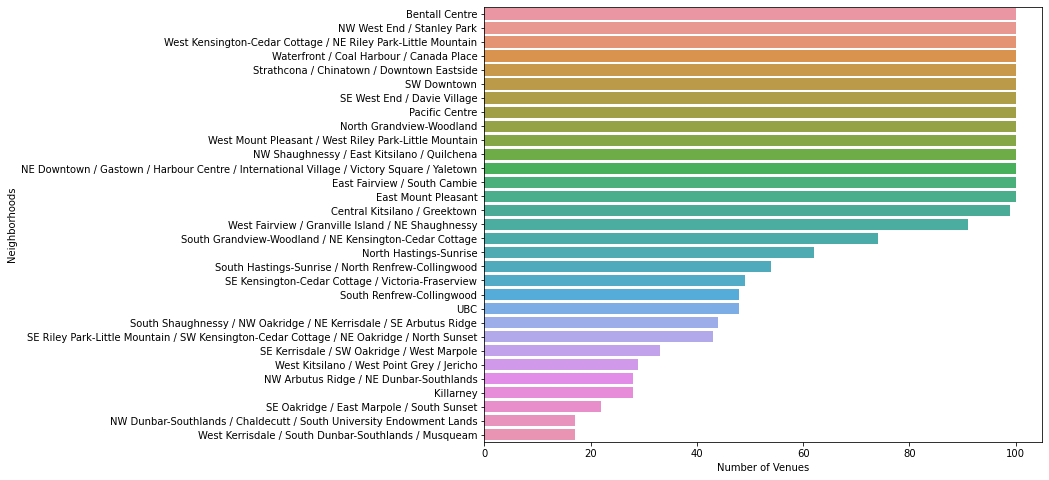

In [11]:
# plot number of venues vs neighborhoods
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))

ax = sns.barplot(x='Venue', y='Neighborhood', data=vancouver_venues_grouped)
ax.set_xlabel('Number of Venues')
ax.set_ylabel('Neighborhoods')

##### Figure 1. Number of venues per neighborhood returned by the Foursquare API.

The dataset has data for all 31 postal code-defined areas being considered. The Foursquare API has returned the max limit of 100 venues for 14 postal code-defined areas, and there are another 10 postal code-defined areas for which the dataset contains over 40 venues, so this information should be enough to complete the desired analysis.

Let's check how many categories we have and which are the most frequent ones:

In [8]:
print('There are {} unique categories.'.format(len(vancouver_venues['Venue Category'].unique())))

There are 236 unique categories.


In [10]:
venue_categories = vancouver_venues.groupby('Venue Category').count().sort_values('Venue', ascending=False)

In [11]:
venue_categories.head(15)

Neighborhood  Neighborhood Latitude  \
Venue Category                                               
Coffee Shop                     145                    145   
Café                             80                     80   
Japanese Restaurant              76                     76   
Hotel                            65                     65   
Park                             64                     64   
Bakery                           63                     63   
Sushi Restaurant                 56                     56   
Chinese Restaurant               52                     52   
Vietnamese Restaurant            51                     51   
Restaurant                       50                     50   
Pizza Place                      48                     48   
Dessert Shop                     42                     42   
Sandwich Place                   40                     40   
Grocery Store                    35                     35   
Breakfast Spot                   34                     34   

                       Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                         
Coffee Shop                               145    145             145   
Café                                       80     80              80   
Japanese Restaurant                        76     76              76   
Hotel                                      65     65              65   
Park                                       64     64              64   
Bakery                                     63     63              63   
Sushi Restaurant                           56     56              56   
Chinese Restaurant                         52     52              52   
Vietnamese Restaurant                      51     51              51   
Restaurant                                 50     50              50   
Pizza Place                                48     48              48   
Dessert Shop                               42     42              42   
Sandwich Place                             40     40              40   
Grocery Store                              35     35              35   
Breakfast Spot                             34     34              34   

                       Venue Longitude  
Venue Category                          
Coffee Shop                        145  
Café                                80  
Japanese Restaurant                 76  
Hotel                               65  
Park                                64  
Bakery                              63  
Sushi Restaurant                    56  
Chinese Restaurant                  52  
Vietnamese Restaurant               51  
Restaurant                          50  
Pizza Place                         48  
Dessert Shop                        42  
Sandwich Place                      40  
Grocery Store                       35  
Breakfast Spot                      34

There are 14 venues in the 'Tea Room' category, 34 venues in the 'Breakfast Spot' category and 1 venue in the 'Creperie' category. These are the categories that I will use to create the clusters, since these types of venues could all be potential competitors for a new Tea Room.

I will not include 'Coffee Shop' and related categories in this analysis because I don't consider these type of venues as direct competitors for the following reasons:

When someone chooses to go to a Tea Room, that person is choosing:

    1) Tea, not coffee
    2) The experience of drinking tea in the relaxed, friendly, usually cozy environment that is a Tea Room
    3) The pastries, sandwiches and/or desserts that usually are served along with the tea

Instead, Coffee shops are frequented by a more diverse public.  Many people like to buy their coffee "on the go", others may stay in the coffee shop to study, work remotely, have an interview, or just hang out with friends, but the overall experience (and the main product: coffee) is different. So these type of venues will not be considered as potential competitors when evaluating an area to open a Tea Room.

In [15]:
venue_categories.reset_index(inplace=True) # reset index to convert 'Venue Category' to a column

Text(0, 0.5, 'Venue Categories')

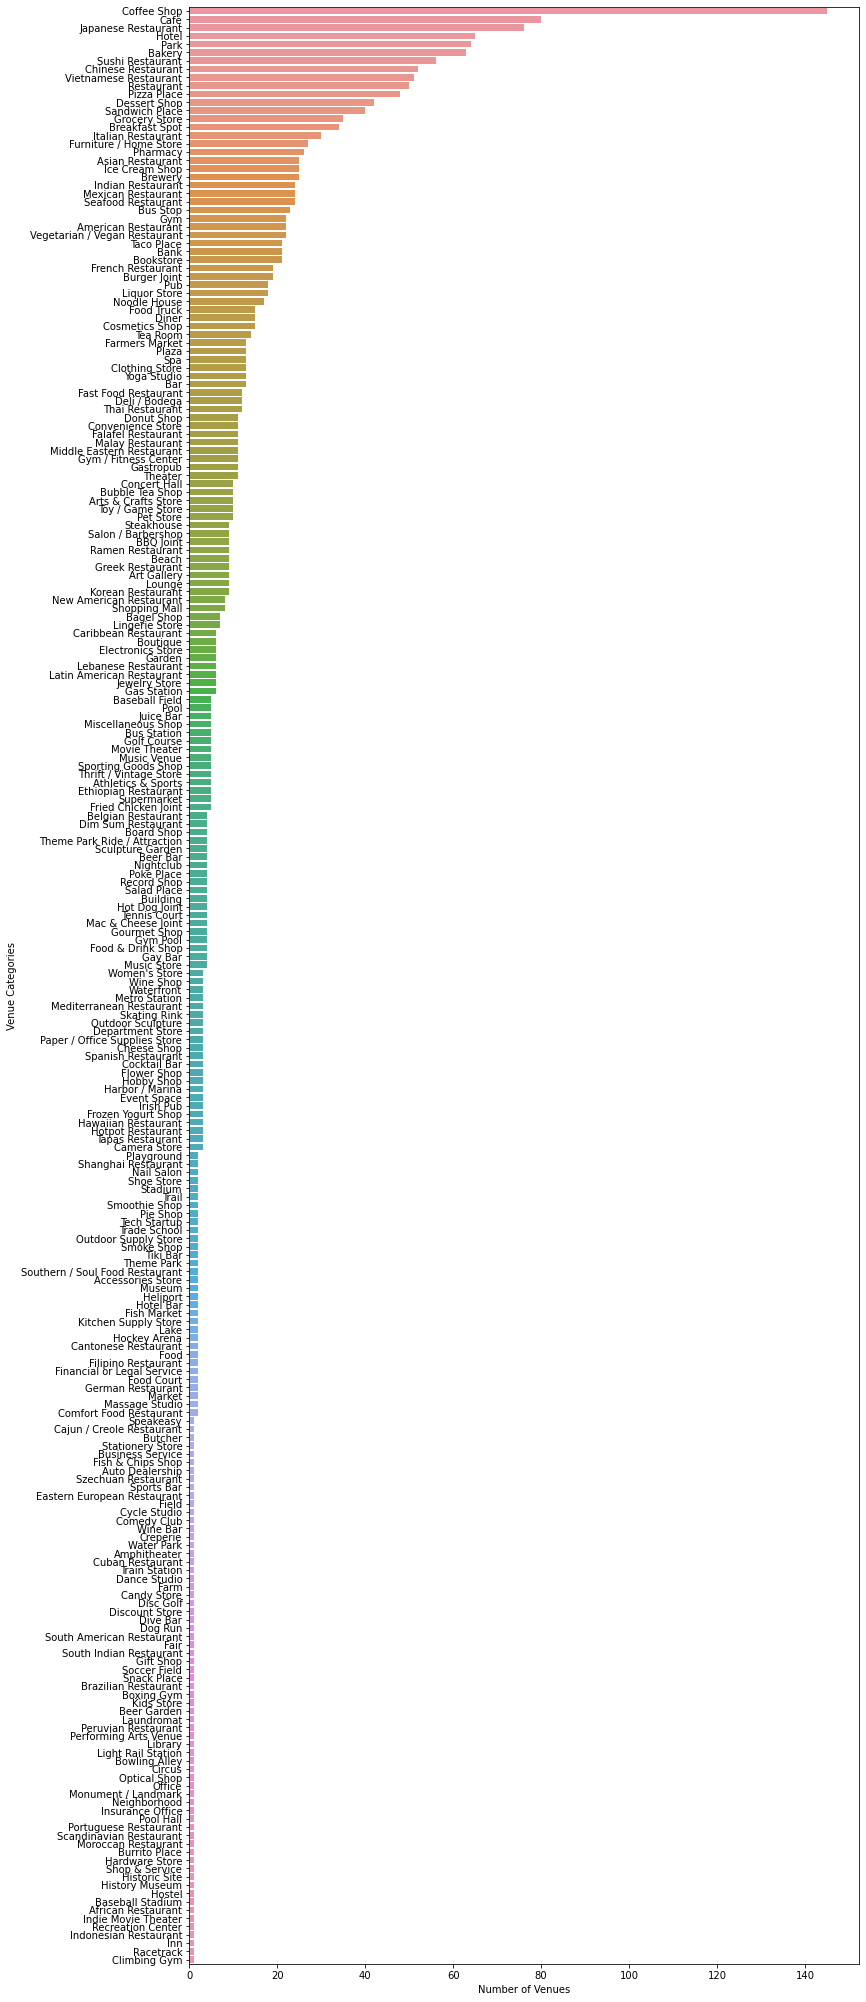

In [16]:
# plot 'Venue Category' vs COUNT('Venue Category')
fig, ax = plt.subplots(figsize=(12,36))

ax = sns.barplot(x='Venue', y='Venue Category', data=venue_categories)
ax.set_xlabel('Number of Venues')
ax.set_ylabel('Venue Categories')

##### Figure 2. Number of venues returned by the Foursquare API for each venue category. 

Before starting with the clustering, let's take a look at where all these venues are located:

In [14]:
### assign color 'red' to 'my_categories' and 'purple' to all other categories
# create a list with the names of the relevant categories for my analysis
my_categories = ['Tea Room', 'Breakfast Spot', 'Creperie']
# get their indexes from vancouver_venues
i_list = vancouver_venues.index[vancouver_venues['Venue Category'].isin(my_categories)].tolist()
# create a list of all Venue Categories
all_categories = list(vancouver_venues['Venue Category'])

colors = []
for i in range(len(all_categories)):
    if i in i_list:
        colors.append('red')
    else:
        colors.append('purple')

In [15]:
# add 'MarkerColor' to the dataframe vancouver_venues
vancouver_venues['MarkerColor'] = colors
vancouver_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  North Hastings-Sunrise              49.283277             -123.043293   
1  North Hastings-Sunrise              49.283277             -123.043293   
2  North Hastings-Sunrise              49.283277             -123.043293   
3  North Hastings-Sunrise              49.283277             -123.043293   
4  North Hastings-Sunrise              49.283277             -123.043293   

                            Venue  Venue Latitude  Venue Longitude  \
0             The Fair at the PNE       49.282971      -123.042109   
1                 Livestock Barns       49.284037      -123.039278   
2                Pacific Coliseum       49.285823      -123.042727   
3  Tamam Fine Palestinian Cuisine       49.281070      -123.051438   
4                        Bao Chau       49.281232      -123.048971   

              Venue Category MarkerColor  
0                       Fair      purple  
1                       Farm      purple  
2               Hockey Arena      purple  
3  Middle Eastern Restaurant      purple  
4      Vietnamese Restaurant      purple

In [14]:
# create map of Vancouver using latitude and longitude values
map_venues = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue, venue_cat, markercolor in zip(vancouver_venues['Venue Latitude'],
                                                   vancouver_venues['Venue Longitude'],
                                                   vancouver_venues['Venue'],
                                                   vancouver_venues['Venue Category'],
                                                   vancouver_venues['MarkerColor'],
                                            ):
    label = '{}, {}'.format(venue, venue_cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=markercolor,
        fill=True,
        fill_color=markercolor,
        fill_opacity=0.2,
        parse_html=False).add_to(map_venues)

map_venues

##### Map 2. Vancoouver's venues. All the venues in this dataset are displayed here with a purple marker, except for the ones that belong to the 'Tea Room', 'Breakfast Spot' or 'Creperie' categories, that are shown with a red marker.

# The map might not be visible on Github. Check out the README for the map.

The northern side of the city has the highest density of venues in this dataset, since that area is the economic heart of Vancouver. I will explore each area's characteristics in more detail later on this analysis.

I will now turn the categorical data about the venues into numerical data using One Hot encoding, where for each neighborhood individual venues are turned into the frequency of how many of those venues are located in each neighborhood.

In [16]:
# # one hot encoding
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")
vancouver_onehot.head()

Accessories Store  African Restaurant  American Restaurant  Amphitheater  \
0                  0                   0                    0             0   
1                  0                   0                    0             0   
2                  0                   0                    0             0   
3                  0                   0                    0             0   
4                  0                   0                    0             0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   0   
1            0                    0                 0                   0   
2            0                    0                 0                   0   
3            0                    0                 0                   0   
4            0                    0                 0                   0   

   Auto Dealership  BBQ Joint  ...  Trail  Train Station  \
0                0          0  ...      0              0   
1                0          0  ...      0              0   
2                0          0  ...      0              0   
3                0          0  ...      0              0   
4                0          0  ...      0              0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Water Park  \
0                              0                      0           0   
1                              0                      0           0   
2                              0                      0           0   
3                              0                      0           0   
4                              0                      1           0   

   Waterfront  Wine Bar  Wine Shop  Women's Store  Yoga Studio  
0           0         0          0              0            0  
1           0         0          0              0            0  
2           0         0          0              0            0  
3           0         0          0              0            0  
4           0         0          0              0            0  

[5 rows x 236 columns]

To create the clusters I will use only venues from the 'Tea Room', 'Breakfast Spot' or 'Creperie' categories. So I will create a subdataframe with only that data:

In [17]:
tea_onehot = vancouver_onehot[['Breakfast Spot', 'Tea Room', 'Creperie']]
tea_onehot.head()

Breakfast Spot  Tea Room  Creperie
0               0         0         0
1               0         0         0
2               0         0         0
3               0         0         0
4               0         0         0

In [18]:
# add neighborhood column back to dataframe
tea_onehot['Neighborhood'] = vancouver_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [tea_onehot.columns[-1]] + list(tea_onehot.columns[:-1])
tea_onehot = tea_onehot[fixed_columns]
tea_onehot = tea_onehot.copy()
# move neighborhood column to the first column
tea_onehot.head()

/home/alina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood  Breakfast Spot  Tea Room  Creperie
0  North Hastings-Sunrise               0         0         0
1  North Hastings-Sunrise               0         0         0
2  North Hastings-Sunrise               0         0         0
3  North Hastings-Sunrise               0         0         0
4  North Hastings-Sunrise               0         0         0

Let's examine the new dataframe's shape:

In [19]:
tea_onehot.shape

(2186, 4)

In [20]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
pd.set_option('display.max_rows', 10)

tea_grouped = tea_onehot.groupby('Neighborhood').mean().reset_index()
tea_grouped

Neighborhood  Breakfast Spot  \
0                                      Bentall Centre        0.010000   
1                       Central Kitsilano / Greektown        0.010101   
2                        East Fairview / South Cambie        0.030000   
3                                 East Mount Pleasant        0.010000   
4                                           Killarney        0.000000   
..                                                ...             ...   
26  West Fairview / Granville Island / NE Shaughnessy        0.032967   
27  West Kensington-Cedar Cottage / NE Riley Park-...        0.030000   
28  West Kerrisdale / South Dunbar-Southlands / Mu...        0.000000   
29         West Kitsilano / West Point Grey / Jericho        0.000000   
30  West Mount Pleasant / West Riley Park-Little M...        0.030000   

    Tea Room  Creperie  
0   0.010000      0.00  
1   0.010101      0.00  
2   0.000000      0.00  
3   0.010000      0.00  
4   0.000000      0.00  
..       ...       ...  
26  0.000000      0.00  
27  0.010000      0.00  
28  0.000000      0.00  
29  0.000000      0.00  
30  0.010000      0.01  

[31 rows x 4 columns]

***

### 3. Cluster Neighborhoods

#### 3.1 Elbow Method to determine the optimal value of k
In order to start working with the k-Means algorithm it is necessary to determine the optimal number of clusters into which the data may be clustered. To do this we iterate the values of k from 1 to 9 and calculate the value of the distortions (_Distortion: the average of the squared distances from the cluster centers of the respective clusters_) and inertia (_Inertia: the sum of squared distances of samples to their closest cluster center_) for each value of k in the given range. The optimal number of clusters will be the value of k at the "elbow" (the point after which the distortion/inertia starts decreasing in a linear fashion).

In [21]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# drop 'Neighborhood' column before clustering
tea_grouped_clustering = tea_grouped.drop('Neighborhood', 1)

In [23]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(tea_grouped_clustering)
    kmeanModel.fit(tea_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(tea_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / tea_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(tea_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / tea_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

#### 3.2 Tabulating and Visualizing the results:

In [24]:
# Using the different values of Distortion:
print("values of Distortion")
for key, val in mapping1.items():
    print(f'{key} : {val}')

# Using the different values of Inertia:
print("\n values of Inertia")
for key, val in mapping2.items():
    print(f'{key} : {val}')

values of Distortion
1 : 0.014486830229479518
2 : 0.00788026017972037
3 : 0.006217781721069326
4 : 0.0028434918609938427
5 : 0.0020426841331946844
6 : 0.0016824626768474403
7 : 0.0013606012614697238
8 : 0.0008142630030767302
9 : 0.00033039203533479487

 values of Inertia
1 : 0.008458282252481603
2 : 0.0030648192617291235
3 : 0.0013610181211970375
4 : 0.0006004946566331683
5 : 0.0003688257265524443
6 : 0.000279323197655976
7 : 0.000194323197655976
8 : 0.00010831982579401827
9 : 3.331982579401826e-05


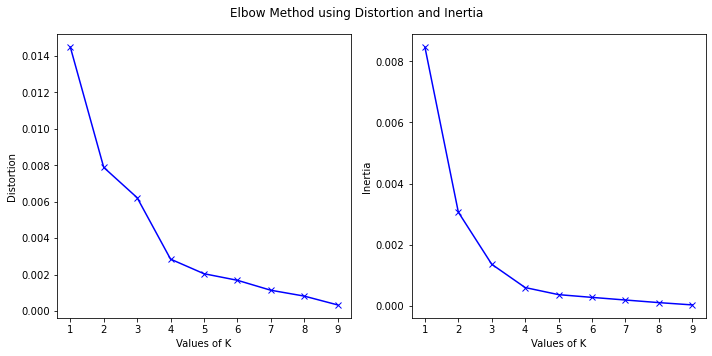

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Elbow Method using Distortion and Inertia')

ax1.plot(K, distortions, 'bx-')
ax1.set(xlabel='Values of K', ylabel='Distortion')

ax2.plot(K, inertias, 'bx-')
ax2.set(xlabel='Values of K', ylabel='Inertia')
fig.tight_layout()

##### Figure 3. Elbow Method to determine the optimal value of k. The left plot shows the result using Distortion and the right plot shows the result using Inertia.

As shown in the plots, for this dataset the optimal value of k is 4. Now I can apply the k-Means algorithm using this value to create the clusters and continue with my analysis:

In [25]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tea_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 2, 1, 2, 2, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster labels as well as the frequencies of the tea-related venues for each neighborhood:

In [26]:
# add clustering labels to the df
tea_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

tea_merged = neighborhoods

# merge dataframes to add latitude/longitude for each neighborhood
tea_merged = tea_merged.join(tea_grouped.set_index('Neighborhood'), on='Neighborhood')

In [27]:
tea_merged

PostalCode       City                                       Neighborhood  \
0         V5K  Vancouver                             North Hastings-Sunrise   
1         V5L  Vancouver                           North Grandview-Woodland   
2         V5M  Vancouver  South Hastings-Sunrise / North Renfrew-Colling...   
3         V5N  Vancouver  South Grandview-Woodland / NE Kensington-Cedar...   
4         V5P  Vancouver  SE Kensington-Cedar Cottage / Victoria-Fraserview   
..        ...        ...                                                ...   
26        V6S  Vancouver  NW Dunbar-Southlands / Chaldecutt / South Univ...   
27        V6T  Vancouver                                                UBC   
28        V6Z  Vancouver                                        SW Downtown   
29        V7X  Vancouver                                     Bentall Centre   
30        V7Y  Vancouver                                     Pacific Centre   

     Latitude   Longitude  Cluster Labels  Breakfast Spot  Tea Room  Creperie  
0   49.283277 -123.043293               2        0.000000      0.00       0.0  
1   49.279853 -123.068277               1        0.030000      0.00       0.0  
2   49.265358 -123.049119               1        0.037037      0.00       0.0  
3   49.259254 -123.072063               2        0.000000      0.00       0.0  
4   49.230668 -123.071843               2        0.000000      0.00       0.0  
..        ...         ...             ...             ...       ...       ...  
26  49.251210 -123.225418               2        0.000000      0.00       0.0  
27  49.271268 -123.239269               2        0.000000      0.00       0.0  
28  49.275885 -123.131725               0        0.000000      0.01       0.0  
29  49.285967 -123.119531               0        0.010000      0.01       0.0  
30  49.282182 -123.119247               0        0.010000      0.01       0.0  

[31 rows x 9 columns]

Let's visualize the clusters in a map. First, let's assign colors to the different cluster labels and add this to 'tea_merged' df in a new column "MarkerColor":

In [27]:
### Assign colors to the different Cluster Labels and replace with these new values the column named 'MarkerColor'
# get a list of labels to iterate over
labels = list(tea_merged['Cluster Labels'])

marker_color = [] 
for label in labels:
    if label == 0:
        marker_color.append('red')
    elif label == 1:
        marker_color.append('blue')
    elif label == 2:
        marker_color.append('green')
    elif label == 3:
        marker_color.append('orange')
# add colors to df in a new column     
tea_merged['MarkerColor'] = marker_color
tea_merged.head()

PostalCode       City                                       Neighborhood  \
0        V5K  Vancouver                             North Hastings-Sunrise   
1        V5L  Vancouver                           North Grandview-Woodland   
2        V5M  Vancouver  South Hastings-Sunrise / North Renfrew-Colling...   
3        V5N  Vancouver  South Grandview-Woodland / NE Kensington-Cedar...   
4        V5P  Vancouver  SE Kensington-Cedar Cottage / Victoria-Fraserview   

    Latitude   Longitude  Cluster Labels  Breakfast Spot  Tea Room  Creperie  \
0  49.283277 -123.043293               2        0.000000       0.0       0.0   
1  49.279853 -123.068277               1        0.030000       0.0       0.0   
2  49.265358 -123.049119               1        0.037037       0.0       0.0   
3  49.259254 -123.072063               2        0.000000       0.0       0.0   
4  49.230668 -123.071843               2        0.000000       0.0       0.0   

  MarkerColor  
0       green  
1        blue  
2        blue  
3       green  
4       green

In [29]:
tea_merged.shape

(31, 10)

In [30]:
# create map of Vancouver showing clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood, markercolor in zip(tea_merged['Latitude'],
                                               tea_merged['Longitude'],
                                               tea_merged['Neighborhood'],
                                               tea_merged['MarkerColor']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=markercolor,
        fill=True,
        fill_color=markercolor,
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)

map_clusters

##### Map 3. K-Means Clustering of Vancouver's Neighborhoods. Cluster 0 is shown with red markers, Cluster 1 is shown with blue markers, Cluster 2 is shown with green markers and Cluster 3 is shown with orange markers.

# The map might not be visible on Github. Check out the README for the map.

## Analysis <a name="analysis"></a>

### Examine clusters

- The map shows that the southern and western areas of Vancouver all belong to one cluster (Cluster 2 - green).
- The northern areas are segmented in 2 clusters (Cluster 0 - red, and Cluster 1 - blue).
- Finally, the last cluster has only one area in it (Cluster 3 - orange).

To analyse these results in more detail, let's begin by checking how many neighborhoods are there in each cluster:

In [28]:
# create a sub dataframe with only 'Neighborhood', 'Cluster Labels', ''Breakfast Spot', 'Tea Room' and 'Creperie' columns in it
neighborhoods_cluster = tea_merged[['Neighborhood', 'Cluster Labels', 'Breakfast Spot', 'Tea Room', 'Creperie']]
# group by cluster label and count the number of neighborhoods in each cluster
neighborhoods_per_cluster = neighborhoods_cluster.groupby('Cluster Labels')['Neighborhood'].count().to_frame()
neighborhoods_per_cluster.reset_index(inplace=True)
neighborhoods_per_cluster

Cluster Labels  Neighborhood
0               0             8
1               1             9
2               2            13
3               3             1

Text(0.5, 1.0, 'Number of Neighborhoods per Cluster')

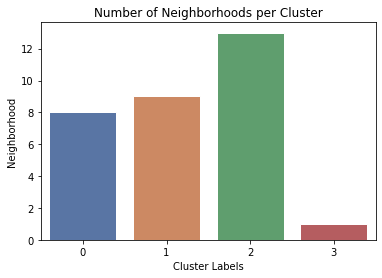

In [32]:
# plot number of neighborhoods vs cluster
fig, ax = plt.subplots(figsize=(6, 4))

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Cluster Labels", y="Neighborhood", data=neighborhoods_per_cluster)
ax.set_title("Number of Neighborhoods per Cluster")

##### Figure 4. Number of neighborhoods grouped in each cluster.

- Cluster 3 has only one neighborhood (postal code area).

- There are 13 neighborhoods (postal codes areas) that have no "Tea&Pastries" shops (Cluster 2).

- Cluster 0 has 8 neighborhoods (postal codes areas) and Cluster 1 has 9 neighborhoods (postal codes areas).

Let's see the frequencies of 'Tea&Pastries' venues for each cluster:

In [29]:
### Wrangle data to create a new df according to what seaborn requires to make a barplot
# create subdf
subdf_tea_merged = tea_merged[['Cluster Labels', 'Breakfast Spot', 'Tea Room', 'Creperie']]
# use df.melt to rearrange data before plotting
data = subdf_tea_merged.melt('Cluster Labels', var_name='Shop', value_name='Frequencies')

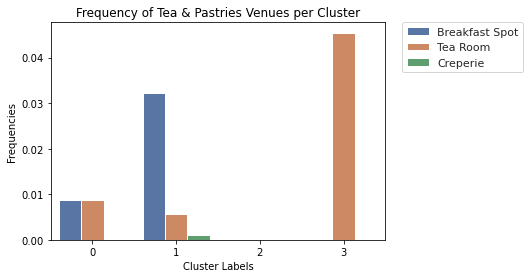

In [30]:
# avg number tea shops vs cluster
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Cluster Labels", y="Frequencies", hue="Shop", data=data, ci=None)
ax.set_title("Frequency of Tea & Pastries Venues per Cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # place legend outside of the plot

##### Figure 5. Frequency of Tea & Pastries venues for each cluster.

From Figure 5, we can see that:

    - There are no "Tea & Pastries" shops in neighborhoods grouped in Cluster 2 (colored green in the clusters' map).
    - Cluster 1 is the cluster with more Breakfast Spots, followed by Cluster 0 (shown in Map 3 with colors blue and red respectively).
    - There is only one Creperie (in Cluster 1), so this venue category wouldn't represent a potentially big competitor.
    - Cluster 3 has the highest frequency of Tea Rooms and no Breakfast Spots.

Now, to find good locations for a new Tea Room, let's check how many 'Tea&Pastries' venues are present in each cluster.

To display this information, I will create a pivot table. To do that, I need a new dataframe with both _'Venue Category' and 'Cluster Labels' as columns_. This needs a bit of data wrangling:

In [31]:
# Create a subdf from vancouver_venues with only 'Tea&Pastries' venue categories in it
my_categories = vancouver_venues[vancouver_venues['MarkerColor'] == 'red']
my_categories = my_categories[['Neighborhood', 'Venue', 'Venue Category', 'Venue Latitude', 'Venue Longitude']]
my_categories.head()

Neighborhood               Venue  \
78                            North Grandview-Woodland               Yolks   
102                           North Grandview-Woodland       The Red Wagon   
160                           North Grandview-Woodland           Euro Cafe   
165  South Hastings-Sunrise / North Renfrew-Colling...  Bon's Off Broadway   
200  South Hastings-Sunrise / North Renfrew-Colling...      Choppers Diner   

     Venue Category  Venue Latitude  Venue Longitude  
78   Breakfast Spot       49.281114      -123.072773  
102  Breakfast Spot       49.281155      -123.057997  
160  Breakfast Spot       49.271559      -123.069603  
165  Breakfast Spot       49.262568      -123.056884  
200  Breakfast Spot       49.261645      -123.056578

In [32]:
# create a list with the cluster labels for each neighborhood
neighborh_49 = list(my_categories['Neighborhood']) # 49 items
# create lists from tea_merged columns to iterate over
clusters_31 = list(tea_merged['Cluster Labels']) # 31 items
neighborh_31 = list(tea_merged['Neighborhood'])  # 31 items
# find cluster labels and append those values to a new list named clusters_49
clusters_49 = []
for n in neighborh_49:
    i = neighborh_31.index(n)
    cluster = clusters_31[i]
    clusters_49.append(cluster)
# check clusters_49 length
len(clusters_49)

49

In [33]:
# add new column to 'my_categories'
my_categories['Cluster Labels'] = clusters_49
# add another column with a value of 1 in each row named 'Number of Venues'
num_venues = [1 for x in range(49)]
my_categories['Number of Venues'] = num_venues
print(my_categories.shape)
my_categories.head()

(49, 7)


Neighborhood               Venue  \
78                            North Grandview-Woodland               Yolks   
102                           North Grandview-Woodland       The Red Wagon   
160                           North Grandview-Woodland           Euro Cafe   
165  South Hastings-Sunrise / North Renfrew-Colling...  Bon's Off Broadway   
200  South Hastings-Sunrise / North Renfrew-Colling...      Choppers Diner   

     Venue Category  Venue Latitude  Venue Longitude  Cluster Labels  \
78   Breakfast Spot       49.281114      -123.072773               1   
102  Breakfast Spot       49.281155      -123.057997               1   
160  Breakfast Spot       49.271559      -123.069603               1   
165  Breakfast Spot       49.262568      -123.056884               1   
200  Breakfast Spot       49.261645      -123.056578               1   

     Number of Venues  
78                  1  
102                 1  
160                 1  
165                 1  
200                 1

In [34]:
# create pivot table to check how many 'Tea&Pastries' venues are present in each cluster.
table = pd.pivot_table(my_categories, values='Number of Venues', 
                       index=['Cluster Labels', 'Neighborhood'], 
                       columns=['Venue Category'], 
                       aggfunc=np.sum).fillna(0)

In [35]:
pd.set_option('display.max_rows', None)
table

Venue Category                                                     Breakfast Spot  \
Cluster Labels Neighborhood                                                         
0              Bentall Centre                                                 1.0   
               Central Kitsilano / Greektown                                  1.0   
               East Mount Pleasant                                            1.0   
               Pacific Centre                                                 1.0   
               SE West End / Davie Village                                    1.0   
               SW Downtown                                                    0.0   
               Strathcona / Chinatown / Downtown Eastside                     1.0   
               Waterfront / Coal Harbour / Canada Place                       1.0   
1              East Fairview / South Cambie                                   3.0   
               NE Downtown / Gastown / Harbour Centre / Intern...             3.0   
               NW Shaughnessy / East Kitsilano / Quilchena                    4.0   
               NW West End / Stanley Park                                     3.0   
               North Grandview-Woodland                                       3.0   
               South Hastings-Sunrise / North Renfrew-Collingwood             2.0   
               West Fairview / Granville Island / NE Shaughnessy              3.0   
               West Kensington-Cedar Cottage / NE Riley Park-L...             3.0   
               West Mount Pleasant / West Riley Park-Little Mo...             3.0   
3              South Shaughnessy / NW Oakridge / NE Kerrisdale...             0.0   

Venue Category                                                     Creperie  \
Cluster Labels Neighborhood                                                   
0              Bentall Centre                                           0.0   
               Central Kitsilano / Greektown                            0.0   
               East Mount Pleasant                                      0.0   
               Pacific Centre                                           0.0   
               SE West End / Davie Village                              0.0   
               SW Downtown                                              0.0   
               Strathcona / Chinatown / Downtown Eastside               0.0   
               Waterfront / Coal Harbour / Canada Place                 0.0   
1              East Fairview / South Cambie                             0.0   
               NE Downtown / Gastown / Harbour Centre / Intern...       0.0   
               NW Shaughnessy / East Kitsilano / Quilchena              0.0   
               NW West End / Stanley Park                               0.0   
               North Grandview-Woodland                                 0.0   
               South Hastings-Sunrise / North Renfrew-Collingwood       0.0   
               West Fairview / Granville Island / NE Shaughnessy        0.0   
               West Kensington-Cedar Cottage / NE Riley Park-L...       0.0   
               West Mount Pleasant / West Riley Park-Little Mo...       1.0   
3              South Shaughnessy / NW Oakridge / NE Kerrisdale...       0.0   

Venue Category                                                     Tea Room  
Cluster Labels Neighborhood                                                  
0              Bentall Centre                                           1.0  
               Central Kitsilano / Greektown                            1.0  
               East Mount Pleasant                                      1.0  
               Pacific Centre                                           1.0  
               SE West End / Davie Village                              0.0  
               SW Downtown                                              1.0  
               Strathcona / Chinatown / Downtown Eastside               1.0  
               W

Great! Here we can see how many venues of each category of interest can be found in each area. Let's plot this data to visualize it better:

In [36]:
table_reseted = table.reset_index()

I will add the postal codes to the dataframe because some of the neighborhoods names are very long and this raises an error with Seaborn:

In [37]:
# find postal codes for each neighborhood in table_reseted
postal_codes = list(neighborhoods['PostalCode']) # 31 items
hoods = list(neighborhoods['Neighborhood']) # 31 items
hoods_table = list(table_reseted['Neighborhood']) # 18 items

postal_c_18 = []
for hood in hoods_table:
    i = hoods.index(hood)
    p_code = postal_codes[i]
    postal_c_18.append(p_code)
    
table_reseted['PostalCode'] = postal_c_18
table_reseted.head()

Venue Category  Cluster Labels                   Neighborhood  Breakfast Spot  \
0                            0                 Bentall Centre             1.0   
1                            0  Central Kitsilano / Greektown             1.0   
2                            0            East Mount Pleasant             1.0   
3                            0                 Pacific Centre             1.0   
4                            0    SE West End / Davie Village             1.0   

Venue Category  Creperie  Tea Room PostalCode  
0                    0.0       1.0        V7X  
1                    0.0       1.0        V6K  
2                    0.0       1.0        V5T  
3                    0.0       1.0        V7Y  
4                    0.0       0.0        V6E

In [38]:
# create subdataframes to plot each cluster independently
table_reseted_0 = table_reseted[table_reseted['Cluster Labels'] == 0]
table_reseted_1 = table_reseted[table_reseted['Cluster Labels'] == 1]
table_reseted_3 = table_reseted[table_reseted['Cluster Labels'] == 3]

df_0 = pd.melt(table_reseted_0, 
             id_vars='PostalCode',
             value_vars=['Breakfast Spot', 'Tea Room', 'Creperie'], 
             var_name='Venue Category',
             value_name='Number')
df_1 = pd.melt(table_reseted_1, 
             id_vars='PostalCode',
             value_vars=['Breakfast Spot', 'Tea Room', 'Creperie'], 
             var_name='Venue Category',
             value_name='Number')
df_3 = pd.melt(table_reseted_3, 
             id_vars='PostalCode',
             value_vars=['Breakfast Spot', 'Tea Room', 'Creperie'], 
             var_name='Venue Category',
             value_name='Number')

Text(0.5, 1.0, 'Venues per Postal Code Area - Cluster 0')

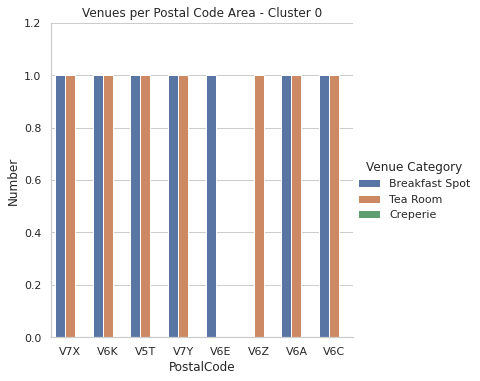

In [39]:
# plot Number of Tea&Pastries venues per Postal Code for Cluster 0
sns.set_theme(style="whitegrid")
ax_0 = sns.catplot(x='PostalCode', y='Number', hue='Venue Category', data=df_0, kind='bar')
ax_0.set(ylim=(0, 1.2))
plt.title('Venues per Postal Code Area - Cluster 0')

##### Figure 6. Number of venues per postal code area for Cluster 0.

__Cluster 0:__ this cluster has almost one 'Breakfast Spot' and one 'Tea Room' per postal code. I looks a little crowded, we'll check that again in Map 4 below.

Text(0.5, 1.0, 'Venues per Postal Code Area - Cluster 1')

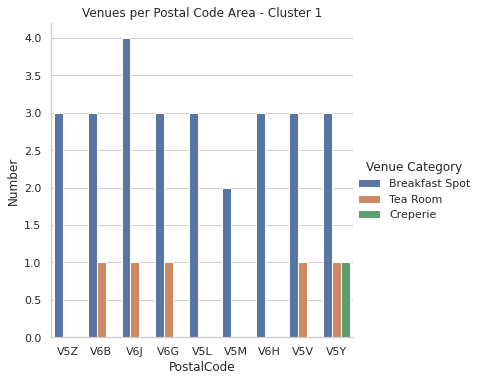

In [40]:
# plot Number of Tea&Pastries venues per Postal Code for Cluster 1
sns.set_theme(style="whitegrid")
ax_1 = sns.catplot(x='PostalCode', y='Number', hue='Venue Category', data=df_1, kind='bar')
ax_1.set(ylim=(0, 4.2))
plt.title('Venues per Postal Code Area - Cluster 1')

##### Figure 7. Number of venues per postal code area for Cluster 1.

__Cluster 1:__ there are many more 'Breakfast Spots' than 'Tea Rooms' in this cluster, and 4 postal codes have no 'Tea Rooms'. We'll explore this areas in more detail to check if we can find a good location for a new Tea Room.

Text(0.5, 1.0, 'Venues per Postal Code Area - Cluster 3')

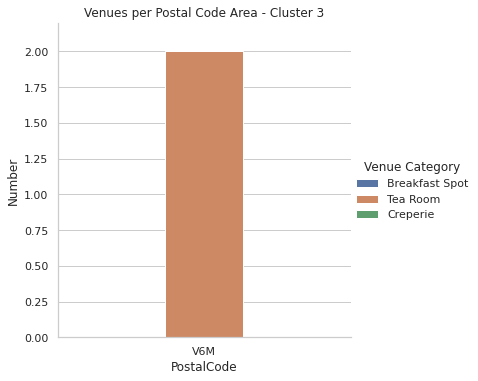

In [41]:
# plot Number of Tea&Pastries venues per Postal Code for Cluster 3
sns.set_theme(style="whitegrid")
ax_3 = sns.catplot(x='PostalCode', y='Number', hue='Venue Category', data=df_3, kind='bar')
ax_3.set(ylim=(0, 2.2))
plt.title('Venues per Postal Code Area - Cluster 3')

##### Figure 8. Number of venues per postal code area for Cluster 3.

__Cluster 3:__ in this cluster there are only two Tea Rooms, and no 'Breakfast Spots' nor 'Creperies'. As explained before, this is a mostly residential area, so even if there are only 2 venues here, it may already be a little crowded. We'll analyze this further below.

Let's now create a map to visualize the location of each of these 'Tea & Pastries' venues:

In [42]:
### Assign colors to the different Cluster Labels and replace with these new values the column named 'MarkerColor'
# get a list of labels to iterate over
labels = list(my_categories['Venue Category'])

marker_color = [] 
for label in labels:
    if label == 'Breakfast Spot':
        marker_color.append('red')
    elif label == 'Tea Room':
        marker_color.append('orange')
    elif label == 'Creperie':
        marker_color.append('purple')
# add colors to df in a new column     
my_categories['MarkerColor'] = marker_color
my_categories.head()

Neighborhood               Venue  \
78                            North Grandview-Woodland               Yolks   
102                           North Grandview-Woodland       The Red Wagon   
160                           North Grandview-Woodland           Euro Cafe   
165  South Hastings-Sunrise / North Renfrew-Colling...  Bon's Off Broadway   
200  South Hastings-Sunrise / North Renfrew-Colling...      Choppers Diner   

     Venue Category  Venue Latitude  Venue Longitude  Cluster Labels  \
78   Breakfast Spot       49.281114      -123.072773               1   
102  Breakfast Spot       49.281155      -123.057997               1   
160  Breakfast Spot       49.271559      -123.069603               1   
165  Breakfast Spot       49.262568      -123.056884               1   
200  Breakfast Spot       49.261645      -123.056578               1   

     Number of Venues MarkerColor  
78                  1         red  
102                 1         red  
160                 1         red  
165                 1         red  
200                 1         red

In [48]:
# create map of Vancouver showing clusters
map_tea_venues = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, neighborhood, markercolor in zip(my_categories['Venue Latitude'],
                                                                 my_categories['Venue Longitude'],
                                                                 my_categories['Neighborhood'],
                                                                 my_categories['MarkerColor']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=markercolor,
        fill=True,
        fill_color=markercolor,
        fill_opacity=0.3,
        parse_html=False).add_to(map_tea_venues)

map_tea_venues

##### Map 4. 'Tea & Pastries' venues of Vancouver. 'Breakfast Spots' are shown in red, 'Tea Rooms' are shown in orange and 'Creperie' is shown in purple.

# The map might not be visible on Github. Check out the README for the map.

On Map 4 we can see that most Tea Rooms in Vanouver are spread out between neighborhoods. The only exception to this are the two Tea Rooms found on Cluster 3, where they are located just around the corner. Let's now check out what other venues are present in the areas assigned to postal codes V6E (from Cluster 0), V5Z, V5L, V5M  and V6H (from Cluster 1) that have no Tea Rooms:

In [43]:
# Sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
'Neighborhood' in vancouver_onehot.columns

True

There is a Venue Category named 'Neighborhood' in this dataframe, I will drop this column since it is not very informative and it interferes with my analysis:

In [45]:
vancouver_onehot.drop(columns=['Neighborhood'], inplace=True)

In [46]:
'Neighborhood' in vancouver_onehot.columns

False

In [47]:
# add neighborhood column back to dataframe
vancouver_onehot['Neighborhood'] = vancouver_venues['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [vancouver_onehot.columns[-1]] + list(vancouver_onehot.columns[:-1])
vancouver_onehot = vancouver_onehot[fixed_columns]
vancouver_onehot = vancouver_onehot.copy()
# move neighborhood column to the first column
vancouver_onehot.head()

Neighborhood  Accessories Store  African Restaurant  \
0  North Hastings-Sunrise                  0                   0   
1  North Hastings-Sunrise                  0                   0   
2  North Hastings-Sunrise                  0                   0   
3  North Hastings-Sunrise                  0                   0   
4  North Hastings-Sunrise                  0                   0   

   American Restaurant  Amphitheater  Art Gallery  Arts & Crafts Store  \
0                    0             0            0                    0   
1                    0             0            0                    0   
2                    0             0            0                    0   
3                    0             0            0                    0   
4                    0             0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  ...  Trail  \
0                 0                   0                0  ...      0   
1                 0                   0                0  ...      0   
2                 0                   0                0  ...      0   
3                 0                   0                0  ...      0   
4                 0                   0                0  ...      0   

   Train Station  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0              0                              0                      0   
1              0                              0                      0   
2              0                              0                      0   
3              0                              0                      0   
4              0                              0                      1   

   Water Park  Waterfront  Wine Bar  Wine Shop  Women's Store  Yoga Studio  
0           0           0         0          0              0            0  
1           0           0         0          0              0            0  
2           0           0         0          0              0            0  
3           0           0         0          0              0            0  
4           0           0         0          0              0            0  

[5 rows x 236 columns]

In [48]:
vancouver_grouped = vancouver_onehot.groupby('Neighborhood').mean().reset_index()

In [49]:
vancouver_grouped.shape

(31, 236)

In [50]:
vancouver_grouped

Neighborhood  Accessories Store  \
0                                      Bentall Centre               0.00   
1                       Central Kitsilano / Greektown               0.00   
2                        East Fairview / South Cambie               0.00   
3                                 East Mount Pleasant               0.00   
4                                           Killarney               0.00   
5   NE Downtown / Gastown / Harbour Centre / Inter...               0.01   
6             NW Arbutus Ridge / NE Dunbar-Southlands               0.00   
7   NW Dunbar-Southlands / Chaldecutt / South Univ...               0.00   
8         NW Shaughnessy / East Kitsilano / Quilchena               0.00   
9                          NW West End / Stanley Park               0.00   
10                           North Grandview-Woodland               0.00   
11                             North Hastings-Sunrise               0.00   
12                                     Pacific Centre               0.00   
13  SE Kensington-Cedar Cottage / Victoria-Fraserview               0.00   
14         SE Kerrisdale / SW Oakridge / West Marpole               0.00   
15          SE Oakridge / East Marpole / South Sunset               0.00   
16  SE Riley Park-Little Mountain / SW Kensington-...               0.00   
17                        SE West End / Davie Village               0.00   
18                                        SW Downtown               0.00   
19  South Grandview-Woodland / NE Kensington-Cedar...               0.00   
20  South Hastings-Sunrise / North Renfrew-Colling...               0.00   
21                          South Renfrew-Collingwood               0.00   
22  South Shaughnessy / NW Oakridge / NE Kerrisdal...               0.00   
23         Strathcona / Chinatown / Downtown Eastside               0.00   
24                                                UBC               0.00   
25           Waterfront / Coal Harbour / Canada Place               0.01   
26  West Fairview / Granville Island / NE Shaughnessy               0.00   
27  West Kensington-Cedar Cottage / NE Riley Park-...               0.00   
28  West Kerrisdale / South Dunbar-Southlands / Mu...               0.00   
29         West Kitsilano / West Point Grey / Jericho               0.00   
30  West Mount Pleasant / West Riley Park-Little M...               0.00   

    African Restaurant  American Restaurant  Amphitheater  Art Gallery  \
0                 0.00             0.040000      0.000000         0.01   
1                 0.00             0.000000      0.000000         0.00   
2                 0.00             0.010000      0.000000         0.01   
3                 0.00             0.000000      0.000000         0.00   
4                 0.00             0.000000      0.000000         0.00   
5                 0.00             0.020000      0.000000         0.01   
6                 0.00             0.000000      0.000000         0.00   
7                 0.00             0.000000      0.000000         0.00   
8                 0.00             0.030000      0.000000         0.00   
9                 0.01             0.000000      0.000000         0.01   
10                0.00             0.000000      0.000000         0.00   
11                0.00             0.016129      0.016129         0.00   
12                0.00             0.010000      0.000000         0.01   
13                0.00             0.000000      0.000000         0.00   
14                0.00             0.000000      0.000000         0.00   
15                0.00             0.000000      0.000000         0.00   
16                0.00             0.000000      0.000000         0.00   
17                0.00             0.020000      0.000000         0.01   
18                0.00             0.000000      0.000000         0.00   
19                0.00             0.013514      0.000000         0.00   
20                0.00             0.000000      0.000

In [51]:
# Create the new dataframe and display the top 10 venues for each neighborhood. 
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vancouver_grouped['Neighborhood']

for ind in np.arange(vancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue  \
0                                      Bentall Centre                 Hotel   
1                       Central Kitsilano / Greektown           Coffee Shop   
2                        East Fairview / South Cambie           Coffee Shop   
3                                 East Mount Pleasant               Brewery   
4                                           Killarney         Grocery Store   
5   NE Downtown / Gastown / Harbour Centre / Inter...                 Hotel   
6             NW Arbutus Ridge / NE Dunbar-Southlands    Italian Restaurant   
7   NW Dunbar-Southlands / Chaldecutt / South Univ...         Shopping Mall   
8         NW Shaughnessy / East Kitsilano / Quilchena           Coffee Shop   
9                          NW West End / Stanley Park           Coffee Shop   
10                           North Grandview-Woodland           Coffee Shop   
11                             North Hastings-Sunrise                  Park   
12                                     Pacific Centre                 Hotel   
13  SE Kensington-Cedar Cottage / Victoria-Fraserview    Chinese Restaurant   
14         SE Kerrisdale / SW Oakridge / West Marpole    Chinese Restaurant   
15          SE Oakridge / East Marpole / South Sunset            Restaurant   
16  SE Riley Park-Little Mountain / SW Kensington-...                  Park   
17                        SE West End / Davie Village                 Hotel   
18                                        SW Downtown                Bakery   
19  South Grandview-Woodland / NE Kensington-Cedar...           Coffee Shop   
20  South Hastings-Sunrise / North Renfrew-Colling...           Pizza Place   
21                          South Renfrew-Collingwood    Chinese Restaurant   
22  South Shaughnessy / NW Oakridge / NE Kerrisdal...    Chinese Restaurant   
23         Strathcona / Chinatown / Downtown Eastside                  Café   
24                                                UBC           Coffee Shop   
25           Waterfront / Coal Harbour / Canada Place                 Hotel   
26  West Fairview / Granville Island / NE Shaughnessy           Coffee Shop   
27  West Kensington-Cedar Cottage / NE Riley Park-...           Coffee Shop   
28  West Kerrisdale / South Dunbar-Southlands / Mu...         Grocery Store   
29         West Kitsilano / West Point Grey / Jericho                  Bank   
30  West Mount Pleasant / West Riley Park-Little M...   Japanese Restaurant   

     2nd Most Common Venue         3rd Most Common Venue  \
0             Dessert Shop           American Restaurant   
1                     Café              Sushi Restaurant   
2      Japanese Restaurant                          Café   
3              Coffee Shop                        Bakery   
4            Shopping Mall                      Bus Stop   
5              Coffee Shop                    Taco Place   
6      Japanese Restaurant              Sushi Restaurant   
7                   Bakery                  Noodle House   
8                   Bakery        Furniture / Home Store   
9             Dessert Shop           Japanese Restaurant   
10                 Brewery                          Café   
11   Vietnamese Restaurant  Theme Park Ride / Attraction   
12             Coffee Shop                          Café   
13   Vietnamese Restaurant           Japanese Restaurant   
14        Sushi Restaurant                          Park   
15       Indian Restaurant          Fast Food Restaurant   
16      Chinese Restaurant                      Bus Stop   
17     Japanese Restaurant                  Dessert Shop   
18                   Hotel            Seafood Restaurant   
19        Sushi Restaurant            Chinese Restaurant   
20   Vietnamese Restaurant        Furniture / Home Store   
21        Asian Restaurant                          Park   
22             Coffee Shop              Sushi Restaurant   
23             Coffee Shop                    Restaurant   
24          

In [53]:
neighborhoods_venues_sorted.head(10)

Neighborhood 1st Most Common Venue  \
0                                     Bentall Centre                 Hotel   
1                      Central Kitsilano / Greektown           Coffee Shop   
2                       East Fairview / South Cambie           Coffee Shop   
3                                East Mount Pleasant               Brewery   
4                                          Killarney         Grocery Store   
5  NE Downtown / Gastown / Harbour Centre / Inter...                 Hotel   
6            NW Arbutus Ridge / NE Dunbar-Southlands    Italian Restaurant   
7  NW Dunbar-Southlands / Chaldecutt / South Univ...         Shopping Mall   
8        NW Shaughnessy / East Kitsilano / Quilchena           Coffee Shop   
9                         NW West End / Stanley Park           Coffee Shop   

  2nd Most Common Venue   3rd Most Common Venue  4th Most Common Venue  \
0          Dessert Shop     American Restaurant                   Café   
1                  Café        Sushi Restaurant                    Pub   
2   Japanese Restaurant                    Café                   Park   
3           Coffee Shop                  Bakery  Vietnamese Restaurant   
4         Shopping Mall                Bus Stop               Pharmacy   
5           Coffee Shop              Taco Place             Restaurant   
6   Japanese Restaurant        Sushi Restaurant                   Bank   
7                Bakery            Noodle House            Coffee Shop   
8                Bakery  Furniture / Home Store             Restaurant   
9          Dessert Shop     Japanese Restaurant                   Café   

  5th Most Common Venue 6th Most Common Venue          7th Most Common Venue  \
0            Restaurant           Coffee Shop                 Cosmetics Shop   
1   Japanese Restaurant         Grocery Store  Vegetarian / Vegan Restaurant   
2              Pharmacy      Sushi Restaurant             Chinese Restaurant   
3           Pizza Place    Mexican Restaurant                 Ice Cream Shop   
4           Coffee Shop    Italian Restaurant                     Restaurant   
5        Sandwich Place          Concert Hall                   Dessert Shop   
6           Coffee Shop          Dessert Shop                       Pharmacy   
7    Frozen Yogurt Shop      Sushi Restaurant                 Farmers Market   
8   Japanese Restaurant        Breakfast Spot                    Yoga Studio   
9      Sushi Restaurant     Korean Restaurant               Sculpture Garden   

           8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0            Japanese Restaurant            Steakhouse                  Plaza  
1                           Park                Bakery      Convenience Store  
2             Mexican Restaurant     Indian Restaurant         Breakfast Spot  
3                     Taco Place      Sushi Restaurant            Music Venue  
4                   Burger Joint        Cosmetics Shop           Liquor Store  
5                           Café    Italian Restaurant         Breakfast Spot  
6                    Pizza Place                  Park         Sandwich Place  
7                           Park           Supermarket                   Bank  
8  Vegetarian / Vegan Restaurant     French Restaurant          Grocery Store  
9                  Grocery Store      Ramen Restaurant  Vietnamese Restaurant

In [54]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(vancouver_data, how='inner', on='Neighborhood')

Let's check what are the top 10 venues in postal code V6E __(Cluster 0)__:

In [55]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['PostalCode'] == 'V6E']

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
17  SE West End / Davie Village                 Hotel   Japanese Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
17          Dessert Shop                Bakery      Sushi Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
17      Ramen Restaurant            Restaurant                  Café   

   9th Most Common Venue 10th Most Common Venue PostalCode       City  
17        Sandwich Place                   Park        V6E  Vancouver

In these neighborhoods, the most common venues (after Hotels) are mainly restaurants. As shown in Figure 6, this area has only one 'Breakfast Spot' and it is not on the top 10.

Now, let's check what are the top 10 venues in postal codes V5Z, V5L, V5M and V6H __(Cluster 1)__:

In [60]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['PostalCode'] == 'V5Z']

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2  East Fairview / South Cambie           Coffee Shop   Japanese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2                  Café                  Park              Pharmacy   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2      Sushi Restaurant    Chinese Restaurant    Mexican Restaurant   

  9th Most Common Venue 10th Most Common Venue PostalCode       City  
2     Indian Restaurant         Breakfast Spot        V5Z  Vancouver

Here we find that coffee shops are the 1st and 3rd most common venues, and "Breakfast Spot' can be found only on the 10th place, with 3 venues in this area (see Figure 7).

In [61]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['PostalCode'] == 'V5L']

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
10  North Grandview-Woodland           Coffee Shop               Brewery   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
10                  Café           Pizza Place      Sushi Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
10         Grocery Store   Japanese Restaurant    Italian Restaurant   

   9th Most Common Venue 10th Most Common Venue PostalCode       City  
10     Indian Restaurant         Breakfast Spot        V5L  Vancouver

In this case we see that 'Breakfast Spot' is again in the 10th place, with 3 venues in the area (see Figure 7). On the 6th place we find the 'Grocery Store' category, which indicates that this area has more residents living in it.

In [62]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['PostalCode'] == 'V5M']

Neighborhood 1st Most Common Venue  \
20  South Hastings-Sunrise / North Renfrew-Colling...           Pizza Place   

    2nd Most Common Venue   3rd Most Common Venue 4th Most Common Venue  \
20  Vietnamese Restaurant  Furniture / Home Store        Breakfast Spot   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
20    Chinese Restaurant              Bus Stop        Sandwich Place   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
20                  Park    Dim Sum Restaurant              Pet Store   

   PostalCode       City  
20        V5M  Vancouver

Here we find that 'Breakfast Spot' is the 4th most common venue (so there is possibly more competitors for a new Tea Room), with 2 venues in the area (see Figure 7). The 3rd place is "Furniture/Home Store", the 6th place is "Bus Stop" and the 10th place "Pet Store". All this probably means that this area is not so visited by tourists.

In [63]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['PostalCode'] == 'V6H']

Neighborhood 1st Most Common Venue  \
26  West Fairview / Granville Island / NE Shaughnessy           Coffee Shop   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
26  Furniture / Home Store   Japanese Restaurant                  Bank   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
26        Sandwich Place                  Café        Breakfast Spot   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
26           Pizza Place              Pharmacy                   Park   

   PostalCode       City  
26        V6H  Vancouver

'Breakfast Spot' is the 7th most common venue, with 3 venues in the area (see Figure 7).

Finally, let's check what are the top 10 venues in postal code V6M __(Cluster 3)__:

In [64]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['PostalCode'] == 'V6M']

Neighborhood 1st Most Common Venue  \
22  South Shaughnessy / NW Oakridge / NE Kerrisdal...    Chinese Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
22           Coffee Shop      Sushi Restaurant   Japanese Restaurant   

   5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
22              Bus Stop      Asian Restaurant  Vietnamese Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
22              Pharmacy              Tea Room           Dessert Shop   

   PostalCode       City  
22        V6M  Vancouver

'Tea Room' is the 9th most common venue category,  with 2 venues in the area (see Figure 8).

***

## Results and Discussion <a name="results"></a>

My analysis shows that although there are many Tea Rooms in Vancouver, they are spread out over the city's neighborhoods. As shown in Map 4, there are areas with no Tea Rooms fairly close to the city center.

The k-Means algorithm found four clusters that clearly segment the city according to each areas' inherent characteristics. Vancouver is a city that has grown from an early settlement in the peninsula, in what is now the "Gastown" neighborhood. The northern areas of the city closest to the peninsula, and the peninsula itself, are home to Vancouver's commercial and financial districts, and most of the city's tourist attractions. The k-Means algorithm has found 2 clusters in this area, __Cluster 0__ and __Cluster 1__. Here we find all "Breakfast Spots" and most of the city's Tea Rooms (see Map 4).

The areas included in __Cluster 2__ are mostly residential. The "western half" of this cluster includes some of the most affluent residential neighborhoods, characterized by larger than average lot sizes, with stately homes on tree-lined streets. The "southern half" of Cluster 2 covers some of the most ethnically diverse neighborhoods in Vancouver (see Map 3). These are also mostly residential areas that used to be predominantly working class but rising house prices have made these areas increasingly popular with young professionals and families who can no longer afford houses in areas such as the west side. These areas have become an attractive location for young professionals and artists, and have received an influx of immigrants from China and other South-East Asian countries. In several neighborhoods included in Cluster 2 only a portion of residents speak English as a mother tongue, compared to roughly half of residents in Vancouver as a whole.
In general, we could say that Cluster 2 groups areas of Vancouver that are generally not a popular destination for tourists. The neighborhoods included in this cluster are probably not the best locations to open a new Tea Room and for this reason I have not explored them any further.

__Cluster 3__ includes only one postal code defined area. The neighborhoods in this area are almost-entirely residential, with high average annual household income and the highest average house price in Vancouver. It is also the site of many historical homes, with elegant tree-lined streets and large properties built before or during World War II. The neighborhoods in this postal code are mostly British in character and demographics, and have received an influx of affluent immigrants from Hong Kong. As Cluster 2, this area also is generally not a popular destination for tourists. It does have Tea Rooms, possibly frequented mostly by its residents.

As shown in Figures 6, 7 and 8, there are __postal code defined-areas that have no Tea Rooms__, so I decided to analyse those areas in more detail to find the best possible location for a new Tea Room:

__Cluster 0 - V6E - SE West End / Davie Village:__

In these neighborhoods, the most common venues (after Hotels) are mainly restaurants. This area has only one 'Breakfast Spot' that is not in the top 10. This could be an area to explore by stakeholders. As an argument against this location, Davie Village may not be the most likely area where people would be interested in visiting a Tea Room. This is "Vancouver's gayborhood", the LGBT-friendly neighborhood that in the evening, comes to life as the real epicentre of Vancouver’s gay nightlife scene. The target audience for a Tea Room may just not be there.

__Cluster 1 - V5Z - East Fairview / South Cambie:__

Here we find that coffee shops are the 1st and 3rd most common venues, and "Breakfast Spot' can be found only on the 10th place, with 3 venues in this area (see Figure 7). This may be a good area for stakeholders to explore.  It is close to one of the city's largest parks and is known for a large cluster of medical facilities.

__Cluster 1 - V5M - South Hastings-Sunrise / North Renfrew-Collingwood:__
Here we find that 'Breakfast Spot' is the 4th most common venue (so there is possibly more competitors for a new Tea Room), with 2 venues in the area (see Figure 7). The 3rd place is "Furniture/Home Store", the 6th place is "Bus Stop" and the 10th place "Pet Store". All this means that this area is not so visited by tourists. Since it is located to the east side of Vancouver further away from Downtown and all the tourist attractions, it may not be so interesting for stakeholders.

__Cluster 1 - V6H - West Fairview / Granville Island / NE Shaughnessy:__

'Breakfast Spot' is the 7th most common venue, with 3 venues in the area (see Figure 7). This area is located at the very center of Vancouver's downtown, close to many tourist attractions, so it may be a very interesting area to explore, since there are no Tea Rooms in it.

__Cluster 1 - V5L - North Grandview-Woodland:__

In this case we find that 'Breakfast Spot' is again in the 10th place, with 3 venues in the area (see Figure 7). On the 6th place we find the 'Grocery Store' category, which indicates that this area has more residents living in it. Since it is a commercial and resiential area relatively close to Downtown, this could be a very interesting area for stakeholders. "Commercial Drive" is located in this neighborhood. It is a street packed with small shops that has been a key part of the commercial landscape in Vancouver for nearly a century for its ethnic diversity and the uniqueness of shops that populate it. It is probably the best candidate location to explore in order to open a new Tea Room. 

__Cluster 3 - V6M - South Shaughnessy / NW Oakridge / NE Kerrisdale / SE Arbutus Ridge:__
Finally, in Cluster 3 we find that 'Tea Room' is the 9th most common venue category, with 2 venues in the area (see Figure 8). This is one of the most affluent areas of Vancouver, but it is mainly residential, so it's commercial streets (where the two Tea Rooms are already located) may be too "crowded" to be of interest to stakeholders. Still, it could be good to explore it further before discarding it as an option for a new Tea Room.

The results presented in this study do not imply that these areas are actually _the optimal locations for a new Tea Room_. This is a preliminary analysis to find areas that are not crowded with existing venues that could be competitors for a new Tea Room. The recommended areas should therefore be considered only as a starting point for a more detailed analysis which could eventually result in finding the optimal location after other factors (like rental price, availability of business premises and city planning regulations to name a few) are taken into account.

Keeping all this in mind, after performing this analysis I would recommend the stakeholders to further explore the following locations:

   * __V5L - North Grandview-Woodland &rarr;__ may be visited by residents and tourists, "Commercial Drive", proximity to Downtown
   * __V5Z - East Fairview / South Cambie &rarr;__ proximity to Downtown, not many competitors
   * __V6H - West Fairview / Granville Island / NE Shaughnessy &rarr;__ close to many areas of interest, not many competitors
   
   * __V6M - South Shaughnessy / NW Oakridge / NE Kerrisdale / SE Arbutus Ridge &rarr;__ not the first option but could have potential if further analysis were to show that there is enough market demand among the areas' residents.
***

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify an optimal location for a "Tea Room & Pastries" shop in Vancouver, Canada. After obtaining the geolocation data of the city's neighborhoods and venue data from Foursquare API, a k-Means clustering analysis was performed to group the city's neighborhoods according to this goal. The analysis of the four clusters obtained revealed areas where no Tea Rooms are located. These areas were studied in more detail and as a result, four areas of Vancouver may be presented to potential stakeholders as the most promising neighborhoods to open a Tea Room in Vancouver.
***

## References <a name="references"></a>

* [Vancouver - Wikipedia](https://en.wikipedia.org/wiki/Vancouver)

* [List of postal codes of Canada: V - Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V)

* [Tourism Vancouver](https://www.tourismvancouver.com)

* [Vancouver's offical website](https://vancouver.ca/)

***